In [1]:
import os

# Import installed libraries
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

# Scikit-Learn stuff
import sklearn
from sklearn import preprocessing
from sklearn.model_selection import StratifiedShuffleSplit

# Keras
import tensorflow.keras as keras
import tensorflow as tf

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

In [2]:
np.random.seed(1)
tf.random.set_seed(1)

In [5]:
try:
    from google.colab import drive
    drive.mount('/gdrive')
    core_path = "/gdrive/MyDrive/Space-ML/asteroid_taxonomy/"
except ModuleNotFoundError:
    core_path = ""

# Load the level 2 asteroid data
asteroids_df = pd.read_pickle(os.path.join(core_path, "data/lvl2/", "asteroids.pkl"))

# Allocate the spectra to one array and the classes to another one
asteroids_X = np.array([k["Reflectance_norm550nm"].tolist() for k in asteroids_df["SpectrumDF"]])
asteroids_y = np.array(asteroids_df["Main_Group"].to_list())
asteroids_y_bus = np.array(asteroids_df["Bus_Class"].to_list())

Mounted at /gdrive


In [6]:
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2)

# Create a simple, single train / test split
for train_index, test_index in sss.split(asteroids_X, asteroids_y):

    X_train, X_test = asteroids_X[train_index], asteroids_X[test_index]
    y_train, y_test = asteroids_y[train_index], asteroids_y[test_index]
    y_train_bus, y_test_bus = asteroids_y_bus[train_index], asteroids_y_bus[test_index]

In [7]:
from sklearn import preprocessing

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the training data to fit
# the scaler
scaler = preprocessing.StandardScaler().fit(X_train)

# Transform now the training data
X_train_scaled = scaler.transform(X_train)

# Scale the testing data ...
X_test_scaled = scaler.transform(X_test)

# And expanding the dimensionality for our ConvNet-based Autoencoder
X_train_scaled = np.expand_dims(X_train_scaled, axis=2)
X_test_scaled = np.expand_dims(X_test_scaled, axis=2)

In [8]:
import keras
from keras.layers import Input, Conv1D, Conv1DTranspose, Flatten, Dense, Reshape
from keras.models import Model
from keras.optimizers import Adam

n_inputs = asteroids_X.shape[1]
n_bottleneck = 5

def create_model():
    # Input layer, this time without a normalization layer
    input_layer = Input(shape=(n_inputs, 1))

    # Convolutional Layers
    x = Conv1D(filters=16, kernel_size=3, activation="relu", padding="same")(input_layer)
    x = Conv1D(filters=32, kernel_size=3, activation="relu", padding="same")(x)

    # Encoder ("Bottleneck" of the Autoencoder)
    bottleneck_lay = Flatten()(x)
    bottleneck_lay = Dense(n_bottleneck)(bottleneck_lay)

    # The original shape must be restored and reshaped accordingly
    reset_lay = Dense(49 * 32)(bottleneck_lay)
    reshape_lay = Reshape((49, 32))(reset_lay)

    # First and second hidden decoder layers
    x = Conv1DTranspose(filters=32, kernel_size=3, strides=1, activation="relu", padding="same")(reshape_lay)
    x = Conv1DTranspose(filters=16, kernel_size=3, strides=1, activation="relu", padding="same")(x)

    # Output layer (same size as input layer)
    output_layer = Conv1D(1, 1, padding="same")(x)

    # Create the autoencoder model
    model = Model(inputs=input_layer, outputs=output_layer)

    # Create the encoder model
    encoder_model = Model(inputs=input_layer, outputs=bottleneck_lay)

    return model, encoder_model

model, encoder_model = create_model()

# Compile the model and use a mean squared error (MSE) loss function
model.compile(optimizer='adam', loss='mse')

# Show the model summary
model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 49, 1)]           0         
                                                                 
 conv1d (Conv1D)             (None, 49, 16)            64        
                                                                 
 conv1d_1 (Conv1D)           (None, 49, 32)            1568      
                                                                 
 flatten (Flatten)           (None, 1568)              0         
                                                                 
 dense (Dense)               (None, 5)                 7845      
                                                                 
 dense_1 (Dense)             (None, 1568)              9408      
                                                                 
 reshape (Reshape)           (None, 49, 32)            0     

In [9]:
end_epoch = 500
batch_size = 32

# Early Stopping for our final model
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

history = model.fit(X_train_scaled, X_train_scaled,
                    epochs=end_epoch,
                    batch_size=batch_size,
                    verbose=0,
                    validation_split=0.25,
                    callbacks=[es_callback])

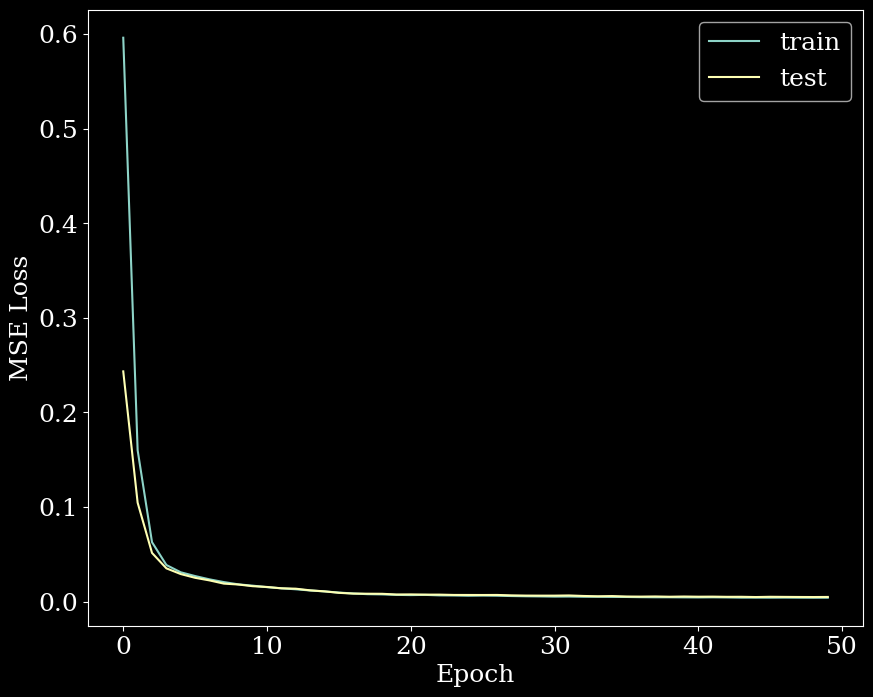

In [10]:
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# plot the training and validation loss
plt.figure(figsize=(10,8))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')

# Add legend and labels
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")

plt.show()

34/34 [==============================] - 0s 4ms/step


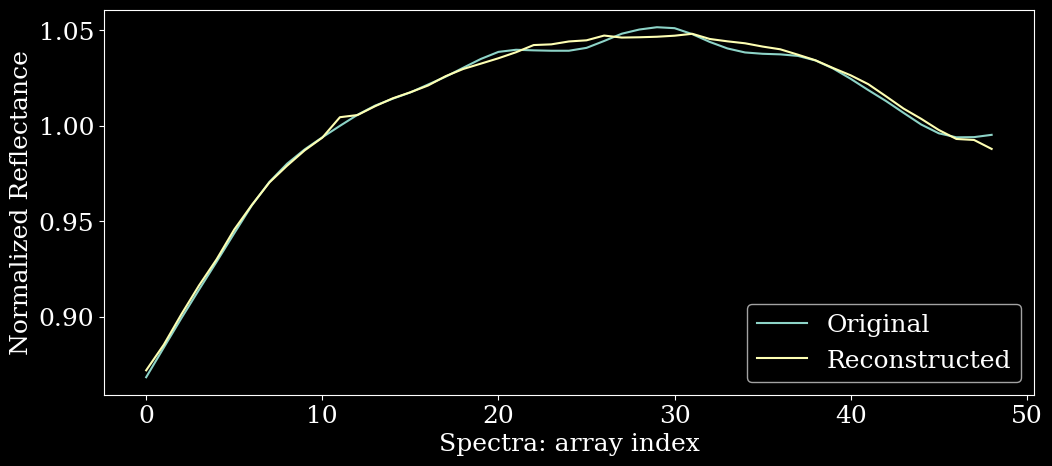

In [11]:
index_val = 5

# Original signal
org_signal = scaler.inverse_transform(X_train_scaled[index_val].reshape(1, -1))[0]
# Reconstructed signal
rec_signal = scaler.inverse_transform(model.predict(X_train_scaled)[index_val].reshape(1, -1))[0]

# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# plot the training and reconstructed data
plt.figure(figsize=(12,5))
plt.plot(org_signal, label='Original')
plt.plot(rec_signal, label='Reconstructed')

# Add legend and labels
plt.legend()
plt.xlabel("Spectra: array index")
plt.ylabel("Normalized Reflectance")

plt.show()

In [13]:
X_train_encoded = encoder_model.predict(X_train_scaled)
X_test_encoded = encoder_model.predict(X_test_scaled)

# Merge the data
X_encoded = np.vstack((X_train_encoded, X_test_encoded))

# Instantiate the StandardScaler (mean 0, standard deviation 1) and use the encoded data to fit
# the scaler
enc_scaler = preprocessing.StandardScaler().fit(X_encoded)

# Transform now the encoded data (later used for our scikit-learn method)
X_encoded_scaled = enc_scaler.transform(X_encoded)

# Merge the classes
y_main = np.hstack((y_train, y_test))
y_bus = np.hstack((y_train_bus, y_test_bus))

# Create a column names array for the encoded space
encoder_space = [f"enc{enc_nr+1}" for enc_nr in range(n_bottleneck)]
encoder_space_cols = encoder_space.copy()
encoder_space.extend(["Main_Group", "Bus_Class"])

# Create the dataframe
encoded_df = pd.DataFrame(np.hstack((X_encoded_scaled,
                                     y_main[np.newaxis].transpose(),
                                     y_bus[np.newaxis].transpose())),
                          columns=encoder_space)

# Change the dtype to float
encoded_df.loc[:, encoder_space[:-2]] = encoded_df.loc[:, encoder_space[:-2]].astype(float)

9/9 [==============================] - 0s 4ms/step


In [14]:
import sklearn.mixture
import tqdm

# Result dataframe that will contain the number of Gaussian components, the Bayesion Information
# Criterion (BIC) and the model itself
gmm_results_df = pd.DataFrame([], columns=["Nr_Comp", "BIC", "Model"])

# We iterate through a number of "component guesses"
max_gauss = 15
for index, gauss_components in tqdm.tqdm(enumerate(np.arange(1, max_gauss+1, 1))):

    # Create and fit a temporary Gaussian Mixture Model
    temp_gmm = sklearn.mixture.GaussianMixture(n_components=gauss_components,
                                               covariance_type="full")
    temp_gmm.fit(X_encoded_scaled)

    # Store the number of components, the BIC and the model
    gmm_results_df.loc[index, "Nr_Comp"] = gauss_components
    gmm_results_df.loc[index, "BIC"] = temp_gmm.bic(X_encoded_scaled)
    gmm_results_df.loc[index, "Model"] = temp_gmm

15it [00:03,  4.31it/s]


(1.0, 15.0)

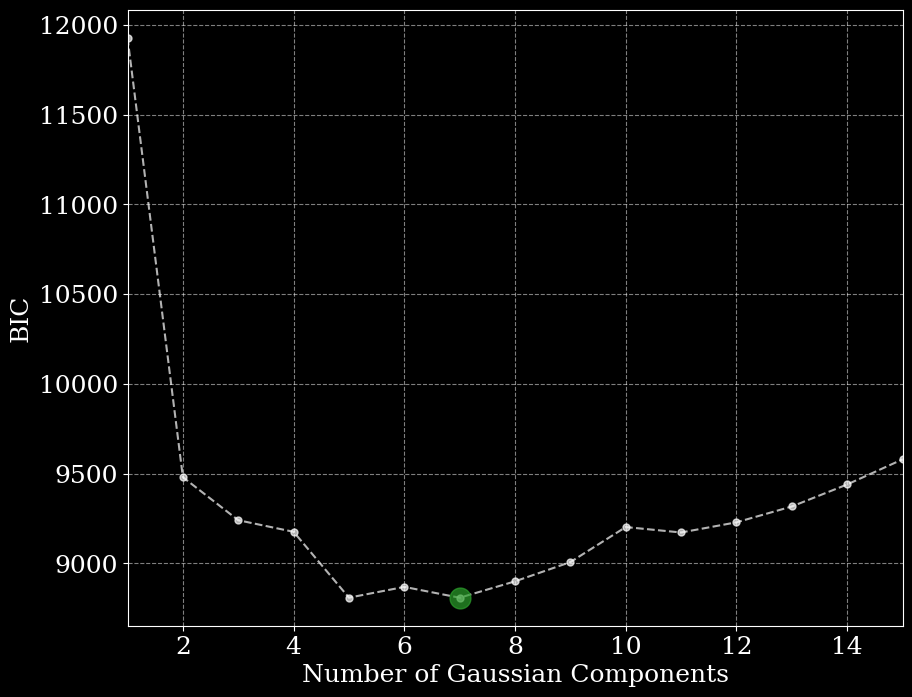

In [19]:
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# Plotting the BIC vs. the number of components
plt.figure(figsize=(10, 8))

plt.plot(gmm_results_df["Nr_Comp"],
         gmm_results_df["BIC"],
         linestyle="dashed",
         marker="o",
         markersize=5,
         color="w",
         alpha=0.7)

# Color the minimum value
gmm_results_best = gmm_results_df.loc[gmm_results_df["BIC"] == gmm_results_df["BIC"].min()]
plt.plot(gmm_results_best["Nr_Comp"],
         gmm_results_best["BIC"],
         marker="o",
         markersize=15,
         color="tab:green",
         alpha=0.7)

# Some formatting
plt.xlabel("Number of Gaussian Components")
plt.ylabel("BIC")
plt.grid(linestyle="dashed", alpha=0.5
         )
plt.xlim(1, max_gauss)

In [16]:
best_gmm = gmm_results_best["Model"].iloc[0]

# Create a new dataframe column that labels the spectra based on our GMM model:
encoded_df.loc[:, "GMM_Class"] = best_gmm.predict(encoded_df[encoder_space_cols].values)

encoded_df

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,GMM_Class
0,-0.891486,1.535026,1.588866,0.499981,1.805664,C,Ch,1
1,-0.955221,0.677896,0.419003,-0.366055,0.437749,X,Xe,4
2,-0.207628,0.105119,0.260267,-0.366496,0.629784,X,Xc,4
3,0.000647,1.210893,0.713201,-0.905745,0.558064,X,X,4
4,-0.923838,0.768052,0.631956,-0.614458,0.658294,C,C,4
...,...,...,...,...,...,...,...,...
1326,-0.598591,0.888653,0.855193,0.067357,0.962579,C,C,1
1327,-0.232942,-0.990991,-0.457752,0.830073,-0.290793,S,S,0
1328,0.318892,-0.048523,-0.06746,-0.683016,-0.529197,S,S,3
1329,0.069643,0.034658,-0.363064,-0.924185,-0.101342,X,Xk,2


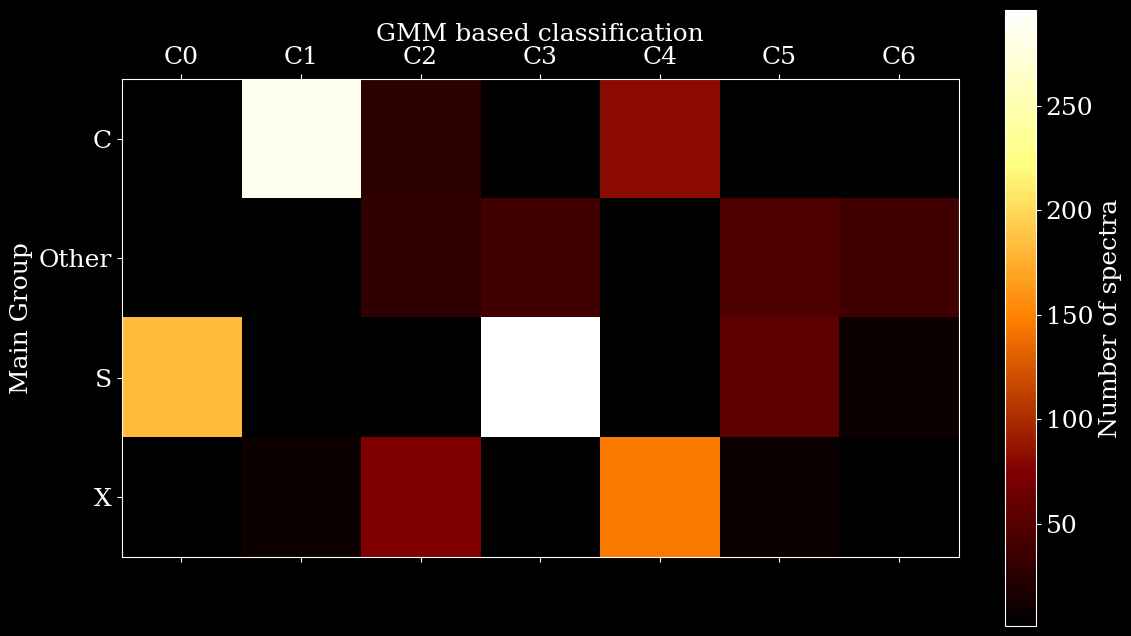

In [20]:
encoded_grouped_df = pd.crosstab(index=encoded_df["Main_Group"],
                                 columns=encoded_df["GMM_Class"],
                                 values=encoded_df["enc1"],
                                 aggfunc="count")

# Extract data, column and index names for plotting purposes
encoded_grouped_values = encoded_grouped_df.values
encoded_grouped_main = encoded_grouped_df.index.values
encoded_grouped_gmm = [f"C{k}" for k in encoded_grouped_df.columns.values]


# Matplotlib settings
# Set the dark mode and the font size and style
plt.style.use('dark_background')
plt.rc('font', family='serif', size=18)

# Create a matrix-like plot of the results
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111)
cax = ax.matshow(encoded_grouped_values, cmap="afmhot")
fig.colorbar(cax, label="Number of spectra", fraction=0.05)

# Some plotting settings
ax.set_xticks(range(len(encoded_grouped_gmm)))
ax.set_yticks(range(len(encoded_grouped_main)))
ax.set_xticklabels(encoded_grouped_gmm)
ax.set_yticklabels(encoded_grouped_main)

ax.set_xlabel("GMM based classification")
ax.set_ylabel("Main Group")
ax.xaxis.set_label_position('top')

In [21]:
encoded_main_s_df = encoded_df.loc[encoded_df["Main_Group"] == "S"].copy()

encoded_main_s_df.groupby("GMM_Class").count()

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class
GMM_Class,,,,,,,
0,182,182,182,182,182,182,182
3,296,296,296,296,296,296,296
5,56,56,56,56,56,56,56
6,9,9,9,9,9,9,9


In [22]:
encoded_grouped_gmm_prob = [f"C{k}Prob" for k in encoded_grouped_df.columns.values]

encoded_main_s_df.loc[:, encoded_grouped_gmm_prob] = \
    best_gmm.predict_proba(encoded_main_s_df[encoder_space_cols].values)

encoded_main_s_df

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,GMM_Class,C0Prob,C1Prob,C2Prob,C3Prob,C4Prob,C5Prob,C6Prob
7,-0.159038,-0.240954,-0.029734,-0.564954,-0.591661,S,S,3,0.017181,3.565220e-10,7.977861e-04,0.977563,1.394122e-15,0.003624,0.000833
8,0.140276,-0.603391,-0.614888,0.041811,-0.962825,S,S,3,0.144243,1.043982e-25,8.164920e-08,0.842858,1.986918e-45,0.012861,0.000038
10,0.534195,-1.231903,-1.384034,0.650324,-0.825523,S,S,0,0.524170,1.764998e-47,4.380811e-11,0.284336,2.266731e-73,0.191468,0.000027
13,-0.588808,-0.544354,0.085019,0.534931,-0.441149,S,S,3,0.431552,8.227966e-16,3.118490e-08,0.563065,1.329266e-32,0.001765,0.003618
15,0.351031,-1.119576,-0.730266,0.432033,-0.838212,S,S,3,0.358008,6.152203e-32,1.501344e-10,0.632420,2.566101e-55,0.009458,0.000114
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1319,-0.253097,-0.548254,0.419563,0.595614,-0.186524,S,Sq,3,0.218278,1.713894e-13,2.317714e-08,0.761696,4.633195e-30,0.001903,0.018123
1321,-0.823695,-0.494132,0.839115,0.428686,-0.126856,S,Sq,3,0.048792,9.785233e-11,8.439888e-09,0.911995,1.586497e-26,0.000546,0.038667
1322,0.59339,-0.90678,-0.880923,-0.076214,-1.063469,S,S,3,0.081549,6.436657e-31,1.697438e-08,0.909008,7.174825e-52,0.009427,0.000016
1327,-0.232942,-0.990991,-0.457752,0.830073,-0.290793,S,S,0,0.584459,8.555981e-25,1.672312e-08,0.396113,6.259249e-40,0.019262,0.000167


Text(0, 0.5, 'Number of spectra')

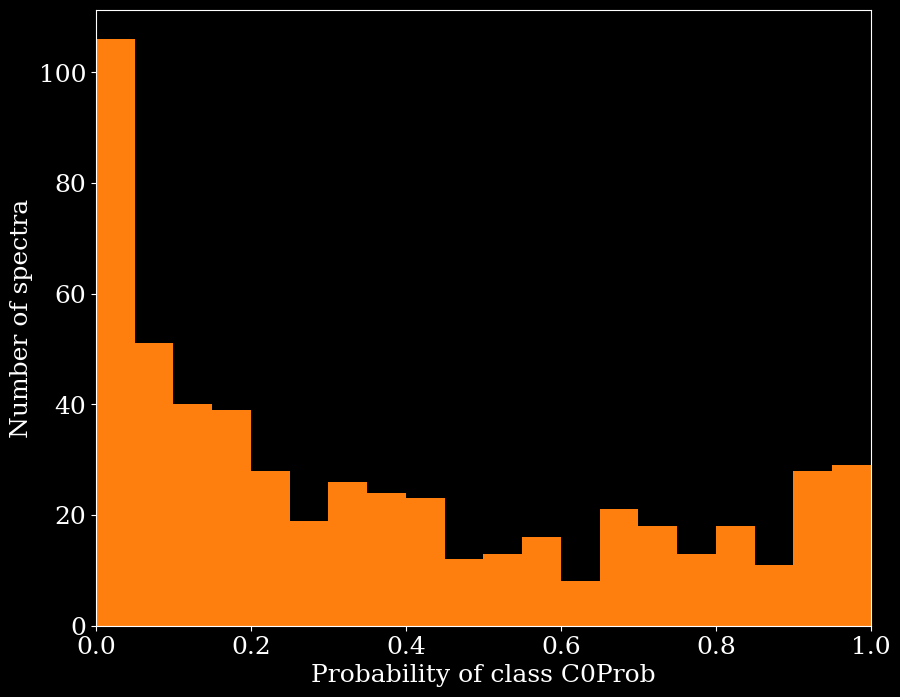

In [23]:
gmm_cl = "C0Prob"

# Let's plot the probability distribution
plt.figure(figsize=(10, 8))

plt.hist(encoded_main_s_df[gmm_cl], bins=np.arange(0, 1.1, 0.05), color="tab:orange")

plt.xlim(0, 1)

plt.xlabel(f"Probability of class {gmm_cl}")
plt.ylabel("Number of spectra")


In [24]:
encoded_main_s_df = encoded_main_s_df.loc[encoded_main_s_df[gmm_cl] >= 0.95]

encoded_main_s_df

,enc1,enc2,enc3,enc4,enc5,Main_Group,Bus_Class,GMM_Class,C0Prob,C1Prob,C2Prob,C3Prob,C4Prob,C5Prob,C6Prob
66,1.208786,-0.887708,-0.505048,0.341817,-0.763509,S,S,0,0.962822,1.212405e-32,1.702687e-11,9.568018e-03,2.186741e-60,0.027378,2.322473e-04
67,-0.325886,-0.370699,-0.465086,0.526936,-0.39237,S,S,0,0.970459,8.001633e-21,4.011382e-07,7.651200e-04,3.269916e-36,0.028250,5.260524e-04
86,0.9535,-0.744405,-0.421812,-0.315168,-0.547247,S,S,0,0.966713,2.221044e-20,6.999902e-07,2.804590e-04,6.404119e-29,0.032951,5.431434e-05
87,-0.870859,-0.422089,-0.807053,1.048367,-0.699307,S,S,0,0.965717,1.524074e-36,4.228031e-16,3.476010e-15,2.302837e-67,0.034282,3.614124e-07
135,0.007129,-0.862526,-0.403275,1.384837,-0.691196,S,S,0,0.981215,1.767683e-38,1.277552e-17,1.515317e-03,9.835148e-82,0.016601,6.683969e-04
162,1.427504,-0.983752,-0.405674,0.014432,-0.761333,S,S,0,0.972152,3.116122e-29,2.200453e-11,2.229737e-06,6.751097e-52,0.027733,1.131550e-04
180,0.891093,-0.872125,-0.50655,-0.373459,-0.754791,S,S,0,0.973015,7.952812e-22,1.862317e-07,4.452838e-04,2.114297e-33,0.026458,8.061353e-05
191,0.437427,-0.799562,-0.086333,0.131009,-0.232734,S,S,0,0.977893,1.229957e-17,1.312070e-07,1.151695e-03,3.178547e-25,0.020879,7.616959e-05
254,-0.176546,-0.389484,0.146877,0.887022,-0.248001,S,Sq,0,0.955764,9.156162e-18,3.364147e-09,5.591307e-03,5.044541e-39,0.011014,2.763068e-02
301,0.93831,-1.232636,-0.792129,0.364026,-0.619057,S,S,0,0.964419,1.336431e-35,4.265745e-11,3.008059e-04,1.053468e-51,0.035267,1.329476e-05


In [25]:
!pip install pingouin
import pingouin

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 198.6/198.6 kB 811.9 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for littleutils: filename=littleutils-0.2.2-py3-none-any.whl size=7028 sha256=e215e5ba424cb9990b4d17b96173ce6fbbd4df7dcdf1bc00649e8dd19237db9b
  Stored in directory: /root/.cache/pip/wheels/3d/fe/b0/27a9892da57472e538c7452a721a9cf463cc03cf7379889266
Successfully built littleutils


In [26]:
encoded_main_s = np.array(encoded_main_s_df[encoder_space_cols].values, dtype="float64")
pingouin.multivariate_normality(encoded_main_s)

HZResults(hz=0.9697167263704419, pval=0.022228969481882615, normal=False)

In [27]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Load your asteroid orbital elements data (replace with your data loading code)
asteroid_data = pd.read_csv('asteroid_data.csv')

# Extract relevant features (orbital elements)
orbital_elements = asteroid_data[['SemiMajorAxis', 'Eccentricity', 'Inclination', 'ArgumentOfPerihelion']]

# Preprocess data: Standardize features to have zero mean and unit variance
scaler = StandardScaler()
orbital_elements_scaled = scaler.fit_transform(orbital_elements)

# Apply Principal Component Analysis (PCA) to reduce dimensionality and capture important information
n_components = 2  # You can adjust the number of components as needed
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(orbital_elements_scaled)

# Visualize the data after dimensionality reduction (PCA)
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
plt.title('PCA of Orbital Elements')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# After visualization, you can further analyze the data and identify patterns or clusters
# Consider clustering techniques (e.g., K-Means, DBSCAN) to group asteroids based on their orbital elements
# Analyze the detected clusters while considering potential detection biases

# Additionally, you can perform statistical tests and modeling to account for biases
# This may include accounting for observation time, equipment characteristics, and survey strategies


FileNotFoundError: ignored

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from google.colab import drive

# Mount Google Drive to access data
drive.mount('/gdrive')

# Load your asteroid data from Google Drive (assuming it's a Pickle file)
data_path = "#path name"
asteroid_data = pd.read_pickle(data_path)

# Extract relevant features (orbital elements)
orbital_elements = asteroid_data[['SemiMajorAxis', 'Eccentricity', 'Inclination', 'ArgumentOfPerihelion']]

# Preprocess data: Standardize features to have zero mean and unit variance
scaler = StandardScaler()
orbital_elements_scaled = scaler.fit_transform(orbital_elements)

# Apply Principal Component Analysis (PCA) to reduce dimensionality and capture important information
n_components = 2  # You can adjust the number of components as needed
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(orbital_elements_scaled)

# Visualize the data after dimensionality reduction (PCA)
plt.figure(figsize=(8, 6))
plt.scatter(principal_components[:, 0], principal_components[:, 1], alpha=0.5)
plt.title('PCA of Orbital Elements')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# After visualization, you can further analyze the data and identify patterns or clusters
# Consider clustering techniques (e.g., K-Means, DBSCAN) to group asteroids based on their orbital elements
# Analyze the detected clusters while considering potential detection biases

# Additionally, you can perform statistical tests and modeling to account for biases
# This may include accounting for observation time, equipment characteristics, and survey strategies
